## ENSEMBLE MODEL (SVM + LSTM)

meta learner is SVM

In [1]:
!pip install tensorflow

In [10]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC  # Support Vector Classifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences


# Load the SVM model, vectorizer, LSTM model, tokenizer, and label encoder
with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('LSTM_label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Load the LSTM model and tokenizer
lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Process the text for SVM and LSTM models
X_test_svm = svm_vectorizer.transform(X_test)  # SVM vectorizer
X_test_lstm = tokenizer.texts_to_sequences(X_test)  # LSTM tokenizer

# Pad sequences for LSTM using keras.preprocessing.sequence.pad_sequences
# This handles variable length sequences correctly
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from the base models
svm_predictions = svm_model.predict(X_test_svm)  # SVM predictions (class labels)

# Instead of predict_classes, use predict and np.argmax
lstm_predictions_proba = lstm_model.predict(X_test_lstm)  # Get probabilities
lstm_predictions = np.argmax(lstm_predictions_proba, axis=-1)  # Get class labels

# Convert base model predictions into probabilities (optional step, based on your setup)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)  # SVM probabilities
lstm_predictions_proba = lstm_model.predict(X_test_lstm)  # LSTM probabilities

# Stack the predictions of both models to create the feature matrix for the meta-learner
stacked_features = np.hstack((svm_predictions_proba, lstm_predictions_proba))

# Train the meta-learner (here we use SVM instead of Logistic Regression)
meta_learner = SVC(probability=True)  # Using SVM as the meta-learner
meta_learner.fit(stacked_features, y_test)

# Save the trained meta-learner (optional, if you want to reuse the model)
with open('meta_learner_svm.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)

# Load the pre-trained meta-learner (if already saved and trained)
with open('meta_learner_svm.pkl', 'rb') as file:
    meta_learner = pickle.load(file)

# Predict using the meta-learner
final_predictions = meta_learner.predict(stacked_features)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, final_predictions)
report = classification_report(y_test, final_predictions, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))


581/581 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step
581/581 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step
Accuracy: 97.09%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.96      0.95      0.96      1999
     bipolar       0.94      0.90      0.92      1941
  depression       0.95      0.95      0.95      1959
      normal       0.98      0.99      0.99     10679
        ptsd       0.96      0.96      0.96      1987

    accuracy                           0.97     18565
   macro avg       0.96      0.95      0.95     18565
weighted avg       0.97      0.97      0.97     18565

Confusion Matrix:
 [[ 1906    17    34    16    26]
 [   12  1743    30   142    14]
 [   32    25  1862    11    29]
 [    7    47     4 10613     8]
 [   27    19    34     6  1901]]


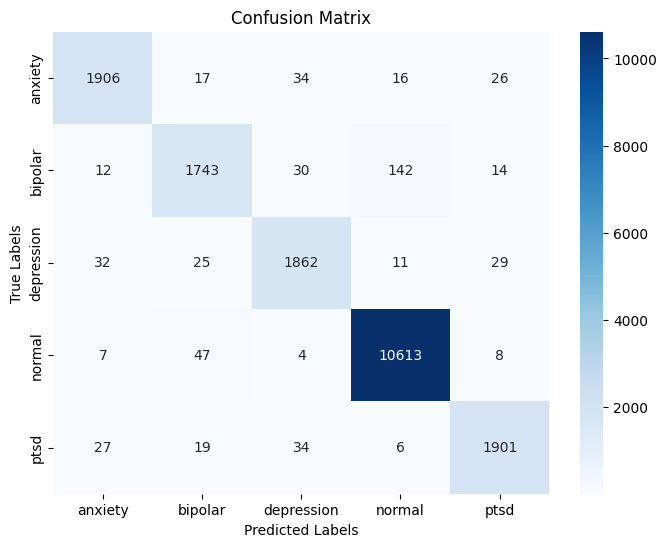

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


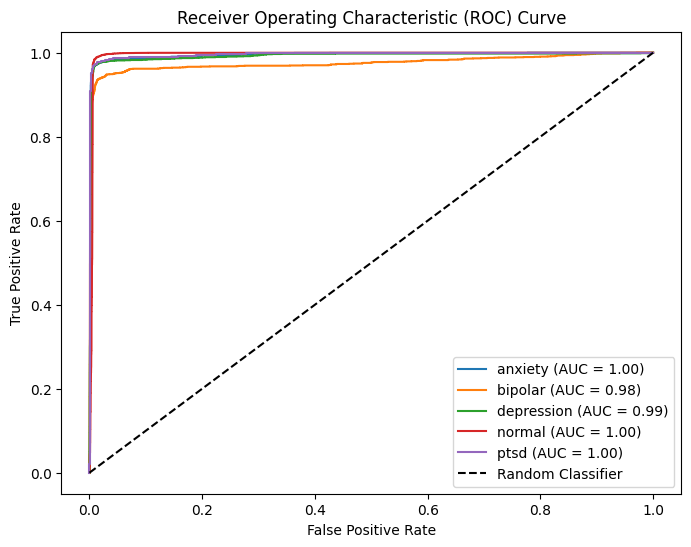

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Get the predicted probabilities for all classes
y_pred_prob = meta_learner.predict_proba(stacked_features)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

# For each class, compute ROC curve and AUC
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Finalize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
